In [1]:
import os
import torch
import pandas as pd
from skimage import io, transform
import numpy as np
import matplotlib.pyplot as plt
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import math

# Ignore warnings
import warnings
warnings.filterwarnings("ignore")
plt.ion()   # interactive mode


In [2]:
class Labels():
    def __init__(self,path):
        self.dataframe = pd.read_csv(path)
        self.transform = LabelTransform(self)
        self.override_params = True
        self.infotype = "Angle"
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, index):
        return self.dataframe.iloc[index][self.infotype]
    
    def histogram(self):
        return self.dataframe[self.infotype].hist()
        

In [3]:
class LabelTransform():
    def __init__(self,labels):
        self.labels = labels.dataframe
        
    def column_rule(self,column_name, function):
        self.labels[column_name] = self.labels.apply(lambda x: function(x.Angle), axis=1)
    

In [4]:
class Images():
    def __init__(self,path):
        self.path = path
        self.transform = ImageTransform()
        self.stack_size = 1
        self.grayscale = False
        
    def image_filename(self,path, number):
        return "{0}{number:06}.jpg".format(path,number=number)
        
    def get_stack(self,index,stack_size):
        img_filenames = [self.image_filename(self.path,i) 
                         for i in range(index, index+stack_size)]
        images = np.array([io.imread(img_filename).transpose((2,0,1)) for img_filename in img_filenames])
        images = self.transform.apply(images)/255
        if not self.grayscale:
            images = np.concatenate(images, axis=0)
        return images
    
    def show(self,stack):
        stack = stack.squeeze()
        if self.grayscale:
            f, ax = plt.subplots(stack_size, 1, figsize=(1*self.stack_size,25))
            ax.imshow(stack,cmap='gray')
            
        else:
            f, ax = plt.subplots(stack_size, 3, figsize=(3*self.stack_size,25))
            ax = ax.reshape((self.stack_size,3))
            for k in range(3*self.stack_size):
                i,j = k//3, k % 3
                ax[i,j].imshow(stack[k],cmap='gray')
                
        
            
    def set_grayscale(self, switch):
        if self.grayscale != switch:
            self.grayscale = switch
            if switch:
                self.transform.add("grayscale")
            else:
                self.transform.remove("grayscale")
        

In [5]:
class ImageTransform():
    def __init__(self):
        self.transformations = []
        
    def apply(self,images):
        for transformation in self.transformations:
            function = getattr(self,transformation)
            images = function(images)
        return images
    
    def add(self,name):
        self.transformations.append(name)
        
    def remove(self,name):
        if name in self.transformations:
            self.transformations.remove(name)
    
    def grayscale(self,images):
        if images.shape[1] != 3:
            return images
        r, g, b = images[:,0,:,:], images[:,1,:,:], images[:,2,:,:]
        gray = 0.2989 * r + 0.5870 * g + 0.1140 * b
        return gray

In [6]:
class ControlsDataset(Dataset):
    """Dataset that maps camera images into steering angle"""
    def __init__(self, stack_size = 1 ,img_folder = '../data/', csv_path='../data/data.csv'):
        self.stack_size = stack_size
        self.images = Images(img_folder)
        self.labels = Labels(csv_path)
    
    def make_dataloaders(self,train=0.8,test=0.2):
        
        indices = list(range(len(self)))
        split = int(np.floor(test * len(self)))

        # spliting the dataset
        train_indices, val_indices = indices[split:], indices[:split]

        # Creating PT data samplers and loaders:
        train_sampler = SubsetRandomSampler(train_indices)
        valid_sampler = SubsetRandomSampler(val_indices)

        # Training data loader # NOTE had to remove shuffle
        self.dataloader = DataLoader(self, batch_size = 32, num_workers = 0, sampler=train_sampler)

        # Validation data loader # NOTE had to remove shuffle
        self.validloader = DataLoader(self, batch_size = 32, num_workers = 0, sampler=valid_sampler)

        print("Total training stacks", len(self.dataloader))
        print("Total validation stacks",len(self.validloader))
    
    def __len__(self):
        return len(self.labels) - self.stack_size
    
    def __getitem__(self, idx):
        #get a stack of images
        image_stack = self.images.get_stack(idx,self.stack_size)
        # use the latest image as the control
        label = self.labels[idx+self.stack_size]
        label = np.array([label])
        #combine stack and label together
        sample = {'image': image_stack, 
                  'control': label}
        return sample

In [7]:
class SampledDataset(ControlsDataset):
    def __init__(self, images, labels):
        self.images = images
        self.labels = labels
        self.unique = {}
        
    def frame_rate(self, frame_rate):
        print(self.labels.dataframe.shape)
        newDataFrame = self.labels.dataframe.iloc[::frame_rate,:]
        print(newDataFrame.shape)
        
        self.labels.dataframe = newDataFrame

(11019, 2)
(1837, 2)
Angle
-1.000000    12
-0.979993     1
-0.956041     1
-0.948057     1
-0.932089     2
-0.908136     1
-0.900152     1
-0.876200     1
-0.860231     1
-0.852247     1
-0.836279     1
-0.804342     2
-0.788374     2
-0.780390     5
-0.756438     1
-0.748453     1
-0.724501     4
-0.708533     5
-0.700549     3
-0.676596     1
-0.660597     1
-0.652613     6
-0.636645     2
-0.628661     3
-0.604708     6
-0.580756     4
-0.564788     7
-0.556803     2
-0.540835     4
-0.532851    12
             ..
 0.261421     1
 0.277390     4
 0.285374     3
 0.317310     1
 0.341293     1
 0.357262     1
 0.365246     3
 0.381214     1
 0.397182     3
 0.413151     1
 0.421135     4
 0.437103     5
 0.453071     3
 0.461055     3
 0.477024     5
 0.548881     1
 0.556865     2
 0.588802     6
 0.596786     2
 0.644691     3
 0.668674     1
 0.692626     1
 0.748515     1
 0.764483     1
 0.780452     2
 0.788436     2
 0.804404     2
 0.828357     2
 0.940134     1
 1.000000    

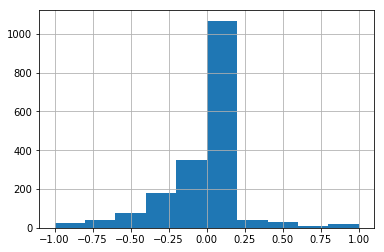

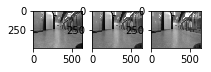

In [11]:
if __name__ == "__main__":
    stack_size = 1
    dataset = ControlsDataset(stack_size)
    dataloader = DataLoader(dataset, batch_size = 4, shuffle = True, num_workers = 0)
    
    img_stack = dataset[0]['image']
    
    sampled_set = SampledDataset(dataset.images, dataset.labels)
    sampled_set.frame_rate(6)
#     sampled_set.categorical_median_sample()
    #print(dataset.labels.dataframe)
#     dataset.labels.frame_rate(4)
    counts = dataset.labels.dataframe.groupby('Angle')['ID'].count()
    print(counts)
    print(max(counts))
    dataset.labels.histogram()
    dataset.images.show(img_stack)